# A script for creating Figure X of the LOVE19 ESSD Paper

- This script assumes it is located inside a subdirectory of the ESSD/Zenodo data.
- The Zenodo directory has an assumed architecture. Note that Zenodo does not allow a directory structure, so the data would need to be reorganized or the directory paths provided would need to be altered in order to run this script.
- The script demonstrates the use of the upper boundary layer elements of LOVE19: SODAR-RASS, LIDAR, FlyFOX-V.

In [1]:
# Data manipulation
import numpy as np
import xarray as xr
import pandas as pd
import pyfocs

# OS interaction
import os

# Plotting libraries
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter
import matplotlib.patches as patches

/Users/karllapo/anaconda3/lib/python3.8/abc.py:85: FutureWarning: xarray subclass DataStore should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


## Format plots

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#3498db", "#FFBF00", "#95a5a6", "#34495e", "#e74c3c", "#9b59b6",]
sns.set_palette(sns.color_palette(flatui))

## Directories

The below command should return the path to the LOVE19 ESSD repository `example-scripts` repository.

In [3]:
dir_notebook = os.getcwd()
dir_essd = os.path.abspath(os.path.relpath(dir_notebook, 'ESSD-repository'))
dir_essd

'/Users/karllapo/Dropbox/DarkMix/proj/DarkMix_Voitsumra/notebook'

In [114]:
# Met data
dir_csat_flux = os.path.join(dir_essd, 'CSAT fluxes')
dir_csat_ts = os.path.join(dir_essd, 'CSAT ts')
dir_aws = os.path.join(dir_essd, 'AWS')

# Figures
dir_print = os.path.join(dir_essd, 'figures')

# DTS data (North Simba and Outer Array)
dir_fods_cross = os.path.join(dir_essd, 'FODS', 'FODS-cross')
dir_flyfox_data = os.path.join(dir_essd, 'FODS', 'FlyFOX')
dir_oa_final = os.path.join(dir_essd, 'FODS', 'outer-array')
dir_heating = os.path.join(dir_essd, 'FODS', 'heating-rates')

# Ground-based remote sensing
dir_sodar = os.path.join(dir_essd, 'remote-sensing', 'SODAR-RASS')
dir_lidar = os.path.join(dir_essd, 'remote-sensing', 'LIDAR')

## Denoising functions

FlyFOX-V data are denoised using a hard-threshold wavelet denoising. The hard threshold is determined for a particular critical wavelength. 

These rely on the python wavelet package, pywt. This step is not strictly necessary.

In [5]:
# Denoising functions
def lowpassfilter(signal, thresh, wavelet="db8", mode='soft', pad='constant'):
    coeff = pywt.wavedec(signal, wavelet, mode=pad)
    if mode == 'firm':
        coeff[1:] = (pywt.threshold_firm(i, np.min(thresh), np.max(thresh)) for i in coeff[1:])    
    else:
        coeff[1:] = (pywt.threshold(i, value=thresh, mode=mode ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="constant" )
    return reconstructed_signal

def lowpassfilter_level(signal, level, wavelet="db8", mode='soft', pad='constant'):
    coeff = pywt.wavedec(signal, wavelet, mode=pad)
    coeff[-level:] = (np.zeros_like(c) for c in coeff[-level:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="constant" )
    return reconstructed_signal


def wv_dc(lv, res, omega_0=4):
    a_e = 2**lv
    length_scale = (a_e * res * np.pi) / (omega_0)
    return(length_scale)

def wavelet_filter(ds, waveletname, lvl, dx, level_or_thresh='level', data_var='theta_v'):
    # Build the xarray Dataset for the denoised data. We will pass this back to the user.
    denoised = xr.Dataset({data_var: (['time', 'z'], np.zeros_like(ds[data_var].values)),},
                          coords={'time': ds.time,
                                  'z': ds.z.values})
    for t in ds.time:
        # Construct the signal to be denoised
        signal_wnans = ds[data_var].sel(time=t)
        signal = signal_wnans.dropna(dim='z')
        signal_mean = signal.mean(dim='z')
        signal = signal - signal_mean

        # Low pass filter using level reduction
        if level_or_thresh == 'level':
            crit_scale = wv_dc(lvl, dx)
            rec = lowpassfilter_level(signal.values, lvl, wavelet=waveletname)
        # Low pass filter using thresholding
        elif level_or_thresh == 'thresh':
            rec = lowpassfilter(signal.values,
                                lvl,
                                wavelet=waveletname,
                                mode='soft')        
            
        # Repad with nans that we removed in the first step
        if rec.size < signal_wnans.size:
            rec = np.append(rec, (np.zeros(signal_wnans.size - rec.size) * np.nan))
        # This handles cases where an extra point was added at the end of the data
        else:
            rec = rec[0:signal_wnans.size]

        # Re-add the mean value and assign to the xarray
        rec = rec + signal_mean.values
        denoised[data_var].loc[dict(time=t)] = rec
        if level_or_thresh == 'level':
            denoised.attrs['crit_scale'] = crit_scale

    return denoised


## Dictionary of times

In [6]:
# UTC flight times for FlyFOX
flight_times = {'LOVE_Flyfox_190718': ['2019-07-18 3:10', '2019-07-18 6:54'],
                'LOVE_Flyfox_190722': ['2019-07-22 3:18', '2019-07-22 6:10'],
                'LOVE_Flyfox_190723': ['2019-07-23 2:59', '2019-07-23 6:30'],
                'LOVE_Flyfox_190726': ['2019-07-26 3:21', '2019-07-26 6:24'],
               }

## AWS

In [7]:
os.chdir(dir_aws)
aws = xr.open_dataset('AWS_Voi_1min.nc')

# DTS Tower data

The FODS-cross directory contains the data with the 12m tower. The data for July 18th is gathered as a dask object, pruned to the flight times and loaded into memory, and the tower data selected. Finally, the z-coordinate is updated from a field site relative coordinate to a height above ground.

In [8]:
os.chdir(dir_fods_cross)
ds_ns_hot = xr.open_mfdataset('*2019-07-18_0[0-7]00*_heated.nc', combine='by_coords').load()
ds_ns_cold = xr.open_mfdataset('*2019-07-18_0[0-7]00*_unheated.nc', combine='by_coords').load()

### Prepare the DTS data

In [9]:
# Select just the tower data
ds_tower_cold = ds_ns_cold.where((ds_ns_cold.unheated == 'tower'), drop=True)
ds_tower_hot = ds_ns_hot.where((ds_ns_hot.heated == 'tower'), drop=True)

# Convert the z coordinate to a height above ground.
# Account for the additional 10cm since we didn't measure the exact bottom.
z_tb = 1.448183004 + 0.1
ds_tower_cold['z'] = ds_tower_cold['z'] + z_tb
ds_tower_hot['z'] = ds_tower_hot['z'] + z_tb

### Calculate wind speed using the vR20 method

In [10]:
# Fiber parameters
rad = 1.34 / 2 * 10**(-3) # radius in meters
volume_per_m = rad ** 2 * np.pi * 1
kg_per_m = 5 / 1000
density = kg_per_m / volume_per_m
density_per_m_fiber = density * volume_per_m

# Heating rate in Wm-2
p = 4.5
params = {
    'rad': rad,
    'crv': 502,
    'density': density_per_m_fiber
}

aws_sub = aws.reindex_like(ds_tower_cold.time, method='nearest')

tower_wind_speed  = pyfocs.wind_speed.calculate(
    ds_tower_hot.cal_temp + 273.15,
    ds_tower_cold.cal_temp + 273.15,
    p,
    (aws_sub['Rlwd (CNR4)'] + aws_sub['Rlwu (CNR4)']),
    method='vR20',
    params=params)

## DTS surface array data

In [11]:
# Outer array - Matrix Inversion Calibration
ds_p1 = xr.open_mfdataset(os.path.join(dir_oa_final, '*2019-07-18_0[0-7]00*_p1.nc'), combine='by_coords').load()
ds_ss_hot = xr.open_mfdataset(os.path.join(dir_oa_final, '*2019-07-18_0[0-7]00*_heated.nc'), combine='by_coords').load()
ds_ss_cold = xr.open_mfdataset(os.path.join(dir_oa_final, '*2019-07-18_0[0-7]00*_unheated.nc'), combine='by_coords').load()

### Select the FlyFOX period

In [12]:
# Enforce that all dimension indices are unique
ds_p1 = pyfocs.xr_helper.xr_unique_index(ds_p1, 'time')
ds_p1 = pyfocs.xr_helper.xr_unique_index(ds_p1, 'xyz')

ds_ss_cold = pyfocs.xr_helper.xr_unique_index(ds_ss_cold, 'time')
ds_ss_cold = pyfocs.xr_helper.xr_unique_index(ds_ss_cold, 'xyz')

ds_ss_hot = pyfocs.xr_helper.xr_unique_index(ds_ss_hot, 'time')
ds_ss_hot = pyfocs.xr_helper.xr_unique_index(ds_ss_hot, 'xyz')

### Outer array wind speed

First, get the LAF-varying heating rate.

In [14]:
# Open the estimated heating rates and assign to the "hot" dataset
ds_or_heat = xr.open_dataset(os.path.join(dir_heating, 'outer-rectangle_heating-rates.nc'))

# We need to build a multi-index (netcdfs do not allow this data type)
midx = pd.MultiIndex.from_arrays(
    [ds_or_heat.x.values,
     ds_or_heat.y.values,
     ds_or_heat.z.values
    ],
    names=('x', 'y', 'z')
)
ds_or_heat = ds_or_heat.drop(['x', 'y', 'z'])
ds_or_heat = ds_or_heat.assign_coords(xyz = midx)

# Now we throw that multiindex away along with repeated values
# e.g., at fiber holders.
ds_or_heat = pyfocs.xr_helper.xr_unique_index(ds_or_heat, 'xyz')

# This is a bit more complicated than other days since the Ultima has a different
# resolution than the XT. We opted to report the heating rate for the XT coordinates,
# so we must interpolate the heating rate to the Ultima coordinates.
ds_or_heat = ds_or_heat.swap_dims({'xyz': 'LAF'}).interp(LAF=ds_ss_hot.LAF)
ds_or_heat = ds_or_heat.isel(time=0)
ds_ss_hot['power'] = ds_or_heat.outer_rectangle

Second, calculatue the wind speed.

In [15]:
# Fiber radius in meters
rad = 1.04 / 2 * 10**(-3)
volume_per_m = rad ** 2 * np.pi * 1
kg_per_m = 3 / 1000
density = kg_per_m / volume_per_m
density_per_m_fiber = density * volume_per_m

params = {
    'rad': rad,
    'crv': 502, # Estimate from vR20. The storage term is small, so the exact value here plays a tertiary role.
    'density': density_per_m_fiber
}

aws_sub = aws.reindex_like(ds_ss_hot.time, method='nearest')

oa_wind_speed = pyfocs.wind_speed.calculate(
    ds_ss_hot.cal_temp + 273.13,
    ds_ss_cold.cal_temp + 273.13,
    ds_ss_hot.power / 2,
    (aws_sub['Rlwd (CNR4)'] + aws_sub['Rlwu (CNR4)']),
    method='vR20',
    params=params
)

# Break into horizontal wind speed components, based on what direction is orthogonal to the fiber.
ns_components = ['OR_SE', 'OR_NW']
logic = [oa_wind_speed.unheated == l for l in ns_components]
logic = xr.concat(logic, dim='locations').any(dim='locations')
wind_speed_ns = oa_wind_speed.where(logic, drop=True)

ew_components = ['OR_SW2', 'OR_SW1', 'OR_NE1', 'OR_NE2']
logic = [oa_wind_speed.unheated == l for l in ew_components]
logic = xr.concat(logic, dim='locations').any(dim='locations')
wind_speed_ew = oa_wind_speed.where(logic, drop=True)

## FlyFOX observations

In [16]:
# Open up the July 18th flight
os.chdir(dir_flyfox_data)
ff_18 = xr.open_dataset('flyfox_180719_thetav.nc')

# Denoising parameters
waveletname = 'bior5.5'
level = 5
dx = 0.127

# Denoise using a hard wavelet threshold
denoised_ff18 = wavelet_filter(ff_18, waveletname, level, dx)
crit_scale = denoised_ff18.crit_scale

# SODAR

In [17]:
os.chdir(dir_sodar)
sodar = xr.open_dataset('LOVE_SODAR_JuneJuly.nc')

# LIDAR

In [18]:
os.chdir(dir_lidar)
lidar = xr.open_dataset('lidar_stares_83s.nc')
lidar_vad = xr.open_dataset('lidar_vad.nc')

# CSAT data

In [19]:
os.chdir(dir_csat_flux)
csat_1min = xr.open_dataset('LOVE19_CSAT_1min_fluxes.v2020-12-03.nc')
csat_qc = xr.open_dataset('LOVE19_CSAT_1min_qaqc.v2020-12-03.nc')

# Prep the data
ft = 'LOVE_Flyfox_190718'
tflight1 =  pd.Timestamp(flight_times[ft][0])
tflight2 = pd.Timestamp('2019-07-18 04:30')
csat_names = ['1m', '4m', '12m']
ds_csat = csat_1min.sel(time=slice(tflight1, tflight2))
ds_csat_qc = csat_qc.sel(time=slice(tflight1, tflight2))

In [131]:
os.chdir(dir_csat_ts)
csat_ts = xr.open_dataset('Love19_CSATS_tsdata_July.nc')
csat_ts['time'] = csat_ts.time - pd.Timedelta(hours=1)
csat_ts = csat_ts.sel(time=slice(tflight1, tflight2))
csat_ts_1s = csat_ts.resample(time='1s').mean()

# Stacked column figure

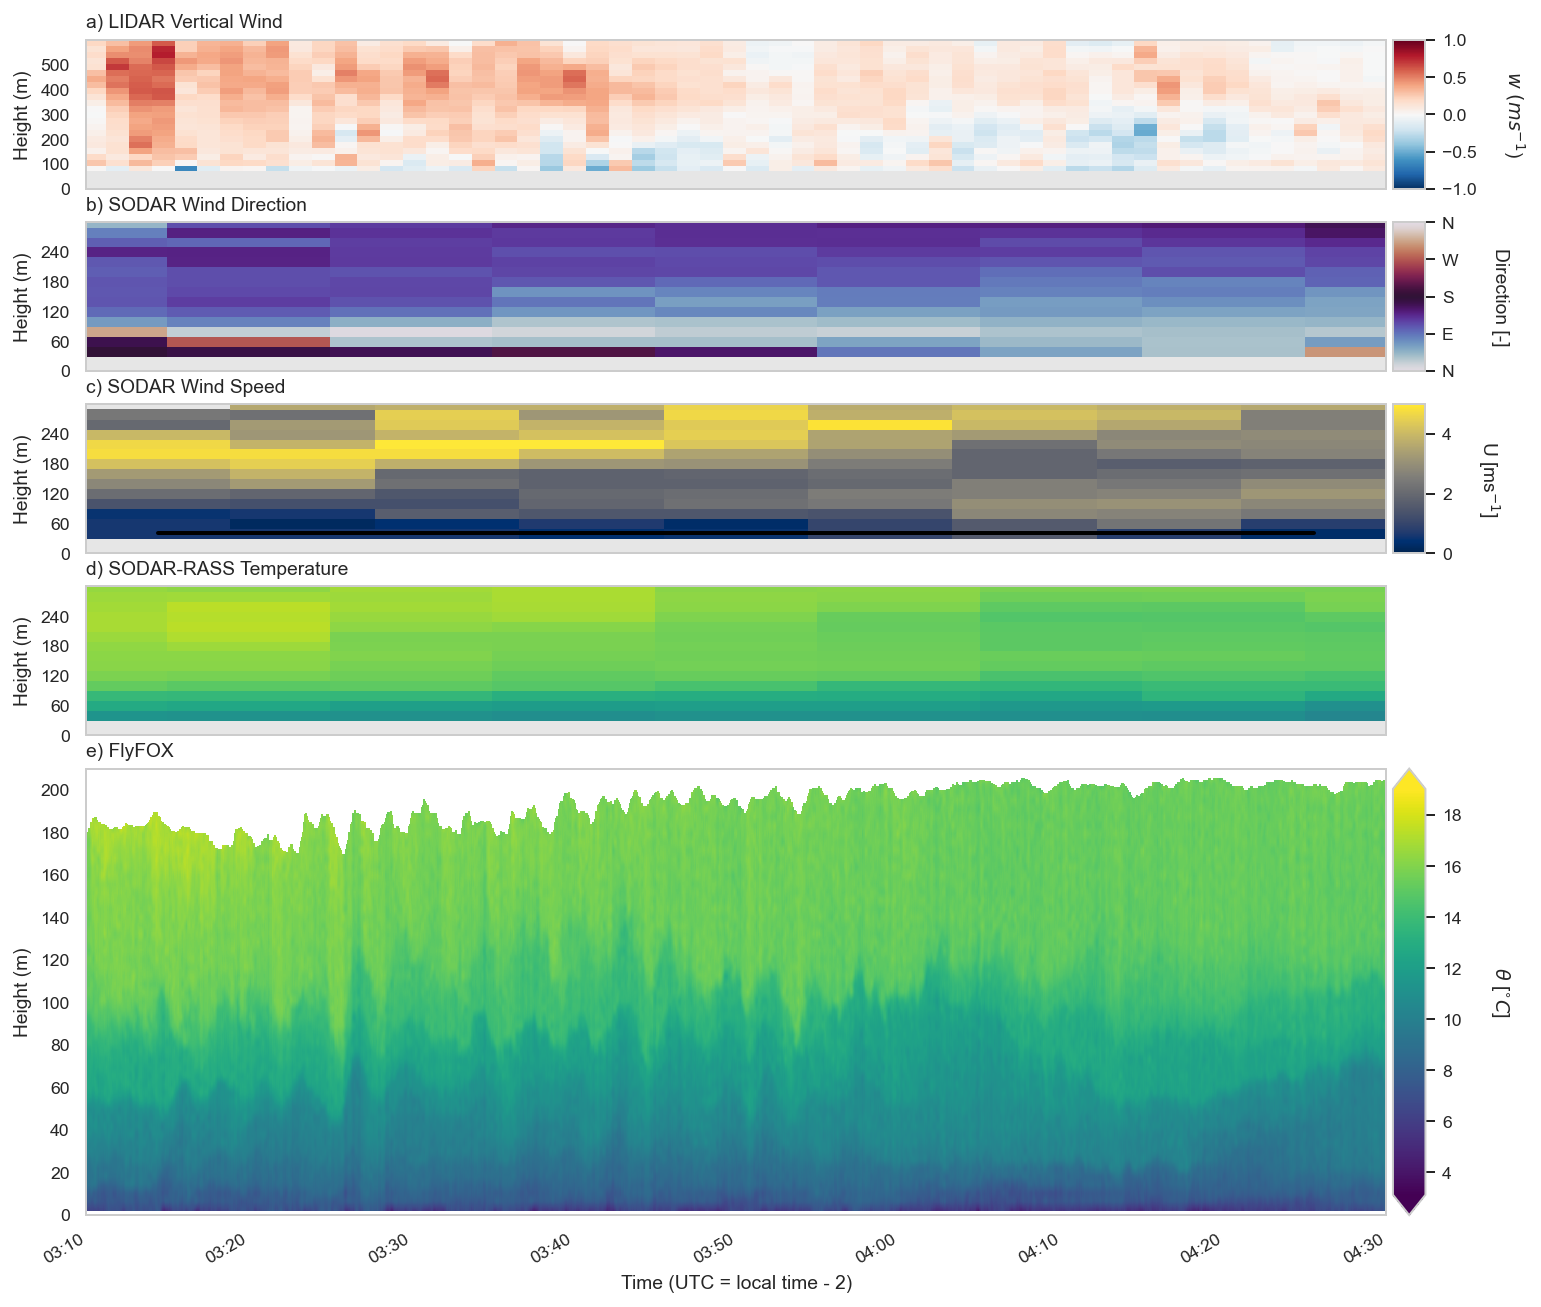

In [179]:
sns.set_context('paper')
# Prep the figure
fig = plt.figure(figsize=(12, 12))
# fig = plt.figure(figsize=(12, 15))

heights = [1, 1, 1, 1, 3]
# heights = [1, 1, 1, 1, 3, 1, 1]

widths = [1, 0.025]
nrows = 5
# nrows = 7
ncols = 2
spec = fig.add_gridspec(ncols=ncols, nrows=nrows,
                        width_ratios=widths,
                        height_ratios=heights,
                        wspace=0.01, hspace=0.16)
ax_maps = []
for row in range(nrows):
    ax_maps.append(fig.add_subplot(spec[row, 0]))
ax_cbar_lidar = fig.add_subplot(spec[0, 1])
ax_cbar_flyfox = fig.add_subplot(spec[4, 1])
ax_cbar_sodar_dir = fig.add_subplot(spec[1, 1])
ax_cbar_sodar_sp = fig.add_subplot(spec[2, 1])
# ax_cbar_tower_u = fig.add_subplot(spec[6, 1])

# Prep the data
ft = 'LOVE_Flyfox_190718'
tflight1 =  pd.Timestamp(flight_times[ft][0])
tflight2 = pd.Timestamp('2019-07-18 04:30')
# tflight2 =  pd.Timestamp(flight_times[ft][1])
vmin = denoised_ff18.theta_v.min() - 273.13
vmax = denoised_ff18.theta_v.max() - 273.13

# Prepare the SODAR-RASS data
t1 = tflight1.floor('10min')
t2 = tflight2.ceil('10min')
fl_sodar = sodar.sel(time=slice(t1, t2))
sodar_z_max = 300
sodar_z_min = 0
sodar_z_ticks = np.arange(sodar_z_min, sodar_z_max, 60)

# Prepare the LIDAR data
fl_lidar = lidar.sel(time=slice(t1, t2))
lidar_z_max = 600
lidar_z_min = 0
lidar_z_ticks = np.arange(lidar_z_min, lidar_z_max, 100)

# LIDAR
ax = ax_maps[0]
ax.set_facecolor('0.9')
color = lidar.mean_w.T.values
im = ax.pcolormesh(
    lidar.time,
    lidar.z,
    color,
    cmap='RdBu_r',
    linewidth=0,
    rasterized=True,
    vmin=-1,
    vmax=1,
    shading='nearest',
)
im.set_edgecolor('face')
ax.set_ylabel('Height (m)')
ax.set_ylim(lidar_z_min, lidar_z_max)
ax.set_yticks(lidar_z_ticks)
ax.set_xlim(pd.Timestamp(tflight1), pd.Timestamp(tflight2))
cbar = fig.colorbar(im, cax=ax_cbar_lidar)
cbar.ax.set_ylabel('$w~ (ms^{-1}$)', rotation=270, labelpad=25)
ax.set_title('a) LIDAR Vertical Wind', loc='left')

# Direction
ax = ax_maps[1]
ax.set_facecolor('0.9')
color = fl_sodar.wind_direction.sel(z=slice(sodar_z_min, sodar_z_max))
im = ax.pcolormesh(
    color.time,
    color.z,
    color.T,
    cmap='twilight',
    linewidth=0,
    rasterized=True,
    vmin=0, 
    vmax=360,
    shading='nearest',
)
im.set_edgecolor('face')
ax.set_ylabel('Height (m)')
ax.set_ylim(sodar_z_min, sodar_z_max)
ax.set_yticks(sodar_z_ticks)
ax.set_xlim(tflight1, tflight2)
cbar = fig.colorbar(im, cax=ax_cbar_sodar_dir)
cbar.ax.set_ylabel('Direction [-]', rotation=270, labelpad=25)
cbar.set_ticks([0, 90, 180, 270, 360])
cbar.ax.set_yticklabels(['N', 'E', 'S', 'W', 'N'])
ax.set_title('b) SODAR Wind Direction', loc='left')

# Speed
ax = ax_maps[2]
ax.set_facecolor('0.9')
color = fl_sodar.wind_speed.sel(z=slice(sodar_z_min, sodar_z_max))
color = color.where(color < 10)
im = ax.pcolormesh(
    color.time,
    color.z,
    color.T.values,
    cmap='cividis',
    vmin=0,
    vmax=5,
    linewidth=0,
    rasterized=True,
    shading='nearest',
)
ax.plot([t1, t2], [40, 40], 'k', linewidth=2)
ax.set_ylabel('Height (m)')
ax.set_ylim(sodar_z_min, sodar_z_max)
ax.set_yticks(sodar_z_ticks)
cbar = fig.colorbar(im, cax=ax_cbar_sodar_sp)
cbar.ax.set_ylabel('U [ms$^{-1}$]', rotation=270, labelpad=25)
ax.set_title('c) SODAR Wind Speed', loc='left')

# Plot the SODAR temperatures
ax = ax_maps[3]
ax.set_facecolor('0.9')
color = fl_sodar.temperature.sel(z=slice(sodar_z_min, sodar_z_max))
color = color.where(color > 0)
ax.pcolormesh(
    color.time,
    color.z,
    color.T.values,
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
    linewidth=0,
    rasterized=True,
    shading='nearest',
)
ax.set_ylabel('Height (m)')
ax.set_ylim(sodar_z_min, sodar_z_max)
ax.set_yticks(sodar_z_ticks)
ax.set_xlim(tflight1, tflight2)
ax.set_title('d) SODAR-RASS Temperature', loc='left')

# Plot the denoised FlyFOX data
ax = ax_maps[4]

im = ax.pcolormesh(
    denoised_ff18.time,
    denoised_ff18.z,
    denoised_ff18.theta_v.rolling(time=3, center=True).mean().T - 273.13,
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
    linewidth=0,
    rasterized=True,
    shading='nearest',
)
ax.set_ylabel('Height (m)')
ax.set_xlabel('Time (UTC = local time - 2)')
fig.autofmt_xdate()
ax.set_ylim(0, 210)
ax.set_yticks(np.arange(0, 220, 20))
ax.set_title('e) FlyFOX', loc='left')
ax.set_xlim(tflight1, tflight2)
plt.colorbar(im, cax=ax_cbar_flyfox, extend='both')
ax_cbar_flyfox.set_ylabel(r'$\theta$ [$^{\circ}C$]', rotation=270, labelpad=25)

# # Plot the smoothed DTS tower data
# ax = ax_maps[5]
# tower_smooth = ds_tower_cold.sel(time=slice(tflight1, tflight2))
# im = ax.pcolormesh(
#     tower_smooth.time,
#     tower_smooth.z + z_tb,
#     (tower_smooth.cal_temp + (tower_smooth.z + z_tb) * 0.01).T.values,
#     cmap='viridis',
#     vmin=vmin,
#     vmax=vmax,
#     linewidth=0,
#     rasterized=True,
#     shading='nearest',
# )
# ax.set_xlim(tflight1, tflight2)
# ax.set_ylim(ds_tower_cold.z.min() + z_tb, ds_tower_cold.z.max() + z_tb)
# ax.set_ylabel('Height [m]')
# ax.set_title('f) Tower FODS - Temperature', loc='left')

# # Plot the FODS of wind speed
# ax = ax_maps[6]
# tower_smooth = tower_wind_speed.sel(time=slice(tflight1, tflight2))
# im = ax.pcolormesh(
#     tower_smooth.time,
#     tower_smooth.z + z_tb,
#     tower_smooth.T.values,
#     cmap='cividis',
#     vmin=0.,
#     vmax=2.5,
#     linewidth=0,
#     rasterized=True,
#     shading='nearest'
# )
# ax.set_xlim(tflight1, tflight2)
# ax.set_ylim(ds_tower_cold.z.min() + z_tb, ds_tower_cold.z.max() + z_tb)
# ax.set_ylabel('Height [m]')
# ax.set_title('g) Tower FODS - Wind Speed', loc='left')

# plt.colorbar(im, cax=ax_cbar_tower_u, extend='max')
# ax_cbar_tower_u.set_ylabel('U [$ms^{-1}$]', rotation=270, labelpad=25)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

os.chdir(dir_print)
fig.savefig('LOVE-Flyfox-190718_column-example.morning-only.v3.pdf', dpi=300, bbox_inches='tight')
fig.savefig('LOVE-Flyfox-190718-column-example.morning-only.v3.png', dpi=300, bbox_inches='tight')

# Surface array data

So far just copy-pastsed from another notebook. Start here tomorrow editing this to show temperature and wind speed along the outer array. If wind speed != interesting, just keep the temperature data.

Current vision is to include the tower, surface DTS array, + CSAT quantity (TKE? Tau?), and (along array?) wind direction in one plot and the column observations in a second plot.

In [22]:
NE_names = {
    'ss': ['OR_NE1', 'OR_NE2'],
    'p1': ['IR_NE1', 'IR_NE2'],
}

SW_names = {
    'ss': ['OR_SW1', 'OR_SW2'],
    'p1': ['IR_SW1', 'IR_SW2'],
}

# -----------------------------------------------------------------
# Inner rim
inner = ds_p1

# Stictch together two segments to create a super segment
inner_sw = inner.where(
    (inner.p1==SW_names['p1'][0]) | (inner.p1==SW_names['p1'][1]),
    drop=True
)
inner_ne = inner.where(
    (inner.p1==NE_names['p1'][0]) | (inner.p1==NE_names['p1'][1]),
    drop=True
)

# Handle the overlapping indices from stitching together
inner_ne = pyfocs.xr_helper.xr_unique_index(inner_ne.swap_dims({'xyz': 'x'}), 'x')
inner_ne = inner_ne.swap_dims({'x': 'p1'})
inner_ne.coords['p1'] = ['IR_NE'] * inner_ne.p1.size
inner_sw = pyfocs.xr_helper.xr_unique_index(inner_sw.swap_dims({'xyz': 'x'}), 'x')
inner_sw = inner_sw.swap_dims({'x': 'p1'})
inner_sw.coords['p1'] = ['IR_SW'] * inner_sw.p1.size

inner_nw = inner.swap_dims({'xyz': 'p1'}).loc[{'p1': 'IR_NW'}]
inner_se = inner.swap_dims({'xyz': 'p1'}).loc[{'p1': 'IR_SE'}]
inner = xr.concat([inner_se, inner_nw, inner_sw, inner_ne], dim='p1')
inner = inner.rename({'p1': 'unheated'})

# -----------------------------------------------------------------
# Outer rim - unheated
outer = ds_ss_cold

# Stictch together two segments to create a super segment
outer_sw = outer.where(
    (outer.unheated==SW_names['ss'][0]) | (outer.unheated==SW_names['ss'][1]),
    drop=True
)
outer_ne = outer.where(
    (outer.unheated==NE_names['ss'][0]) | (outer.unheated==NE_names['ss'][1]),
    drop=True
)

# Handle the overlapping indices from stitching together
outer_ne = pyfocs.xr_helper.xr_unique_index(outer_ne.swap_dims({'xyz': 'x'}), 'x')
outer_ne = outer_ne.swap_dims({'x': 'unheated'})
outer_ne.coords['unheated'] = ['OR_NE'] * outer_ne.unheated.size
outer_sw = pyfocs.xr_helper.xr_unique_index(outer_sw.swap_dims({'xyz': 'x'}), 'x')
outer_sw = outer_sw.swap_dims({'x': 'unheated'})
outer_sw.coords['unheated'] = ['OR_SW'] * outer_sw.unheated.size

outer_nw = outer.swap_dims({'xyz': 'unheated'}).loc[{'unheated': 'OR_NW'}]
outer_se = outer.swap_dims({'xyz': 'unheated'}).loc[{'unheated': 'OR_SE'}]
outer = xr.concat([outer_se, outer_nw, outer_ne, outer_sw], dim='unheated')

In [82]:
# Grab just the NE segment during the plotted period and 
# do a bit of time averaging to make it prettier

tflight1 =  pd.Timestamp(flight_times[ft][0])
tflight2 = pd.Timestamp('2019-07-18 04:10')
tslice = slice(tflight1, tflight2)

section_name = 'IR_NE'
section_name = 'IR_SW'
ds_inner = inner.sel(unheated=section_name).swap_dims({'unheated': 'y'}).sel(time=tslice)
ds_inner = ds_inner.rolling(time=5, center=True).mean()
ds_inner = ds_inner.rolling(y=10, center=True).mean()

section_name = 'OR_NE'
section_name = 'OR_SW'
ds_outer = outer.sel(unheated=section_name).swap_dims({'unheated': 'y'}).sel(time=tslice)
ds_outer = ds_outer.rolling(time=5, center=True).mean()
ds_outer = ds_outer.rolling(y=10, center=True).mean()

In [83]:
# -----------------------------------------------------------------
# Outer rim - wind speed

section_names = ['OR_NE1', 'OR_NE2']
section_names = ['OR_SW1', 'OR_SW2']

logic = [wind_speed_ew.unheated == l for l in section_names]
logic = xr.concat(logic, dim='locations').any(dim='locations')
ds_outer_wind = wind_speed_ew.where(logic, drop=True)
ds_outer_wind = ds_outer_wind.sel(time=tslice)

ds_outer_wind = pyfocs.xr_helper.xr_unique_index(ds_outer_wind.swap_dims({'xyz': 'y'}), 'y')
ds_outer_wind = ds_outer_wind.sortby('y')
ds_outer_wind = ds_outer_wind.rolling(time=5, center=True).mean()
ds_outer_wind = ds_outer_wind.rolling(y=10, center=True).mean()

In [110]:
# Smooth the tower data so it looks prettier
ds_tower_cold_smooth = ds_tower_cold.sel(time=slice(tflight1, tflight2)).swap_dims({'xyz': 'z'})
ds_tower_cold_smooth = ds_tower_cold_smooth.rolling(time=10, center=True).mean()
ds_tower_cold_smooth = ds_tower_cold_smooth.rolling(z=8, center=True).mean()

ds_tower_wind_smooth = tower_wind_speed.sel(time=slice(tflight1, tflight2)).swap_dims({'xyz': 'z'})
ds_tower_wind_smooth = ds_tower_wind_smooth.rolling(time=5, center=True).mean()
ds_tower_wind_smooth = ds_tower_wind_smooth.rolling(z=8, center=True).mean()

In [111]:
def inset_plotter(ds_highlight, others, axins):
    
    for ds_other in others:
        axins.scatter(
            ds_other.x.values,
            ds_other.y.values,
            0.5,
            color='0.8',
            )

    axins.scatter(
        ds_highlight.x.values,
        ds_highlight.y.values,
        0.5,
        color='k'
    )
    
    axins.grid(False)
    axins.set_xticks([])
    axins.set_yticks([])

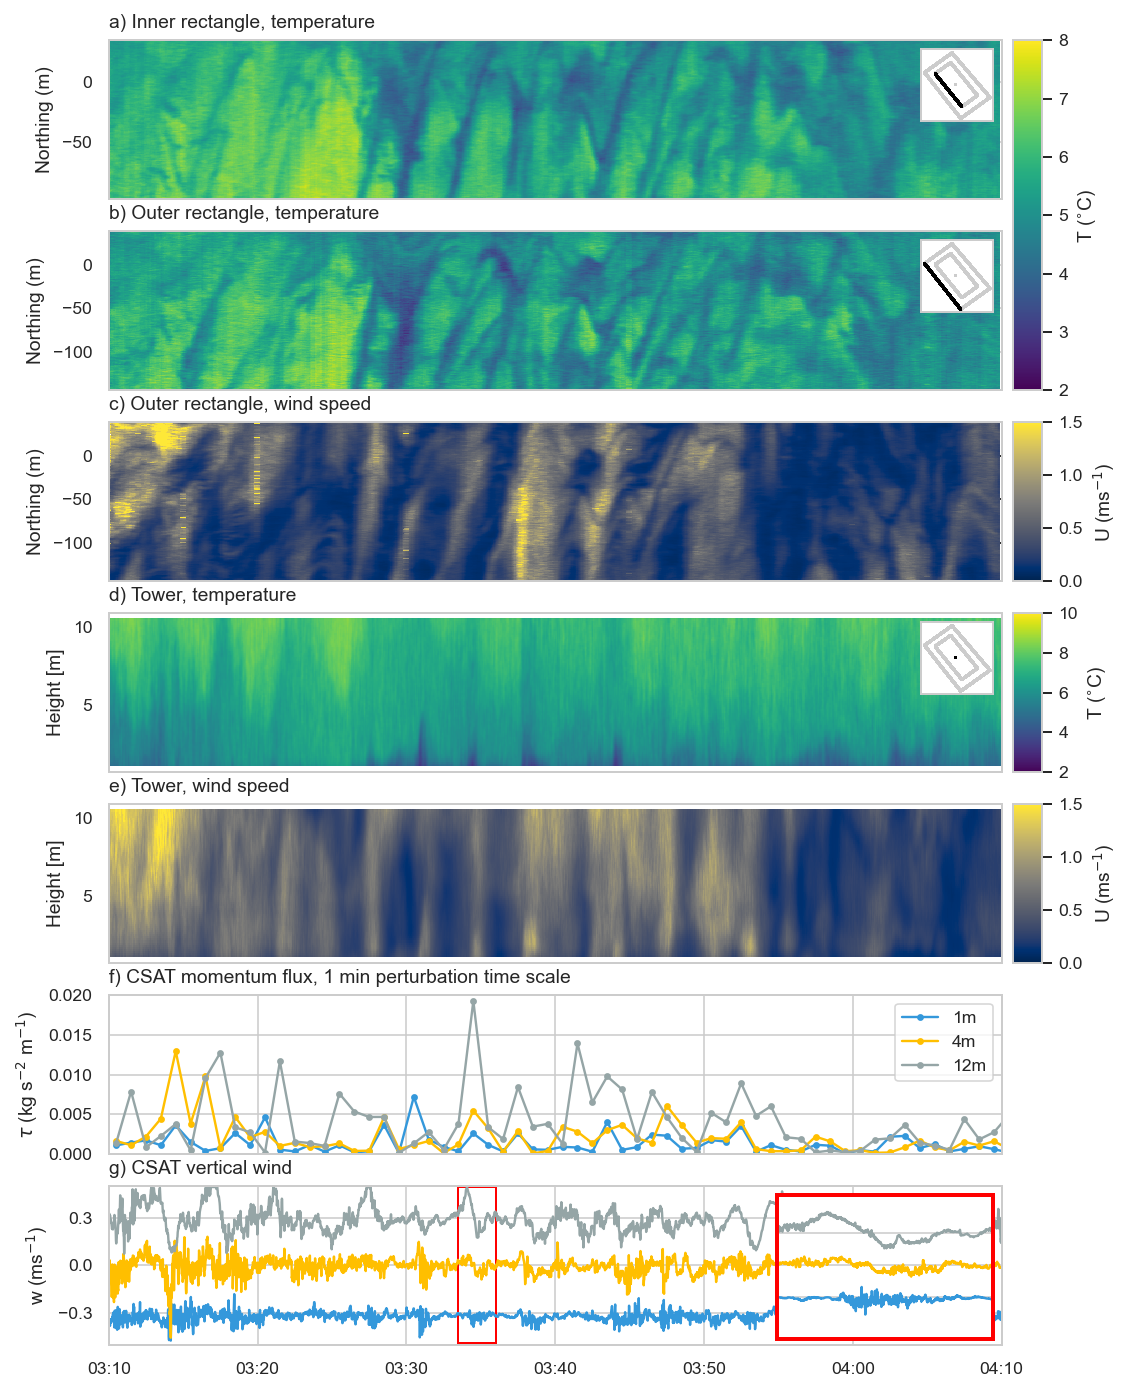

In [184]:
tflight1 =  pd.Timestamp(flight_times[ft][0])
tflight2 = pd.Timestamp('2019-07-18 04:10')
tslice = slice(tflight1, tflight2)

fig, axes = plt.subplots(7, 1, figsize=(8, 12), sharex=True)
vmin = 2
vmax = 8

# Inner rectangle
ax = axes[0]
ax.set_title('a) Inner rectangle, temperature', loc='left')
im = ax.pcolormesh(
    ds_inner.time,
    ds_inner.y.values,
    ds_inner.cal_temp.T, 
    cmap='viridis',
    shading='nearest',
    vmin=vmin,
    vmax=vmax,
)
ax.grid()
ax.set_ylabel('Northing (m)')
pos_ax_a = ax.get_position()

# Inset map
axins = inset_axes(
    ax,
    width=0.5,
    height=0.5,
    loc='upper right'
)
inset_plotter(ds_inner, [ds_p1, ds_ss_cold, ds_tower_cold], axins)

# Outer rectangle
ax = axes[1]
ax.set_title('b) Outer rectangle, temperature', loc='left')
im = ax.pcolormesh(
    ds_outer.time,
    ds_outer.y.values,
    ds_outer.cal_temp.T, 
    cmap='viridis',
    shading='nearest',
    vmin=vmin,
    vmax=vmax,
)
ax.grid()
ax.set_ylabel('Northing (m)')
pos_ax_b = ax.get_position()

# Inset map
axins = inset_axes(
    ax,
    width=0.5,
    height=0.5,
    loc='upper right'
)
inset_plotter(ds_outer, [ds_p1, ds_ss_cold, ds_tower_cold], axins)

# Colorbar
axcbar = fig.add_axes(
    np.array([0.91, pos_ax_b.y0, 0.025, pos_ax_a.y1 - pos_ax_b.y0]))
plt.colorbar(im,
    cax=axcbar,
    orientation="vertical",
    label='T ($^{\circ}$C)',
)

# Outer rectangle FODS wind speed
ax = axes[2]
ax.set_title('c) Outer rectangle, wind speed', loc='left')
im_u = ax.pcolormesh(
    ds_outer_wind.time,
    ds_outer_wind.y.values,
    ds_outer_wind, 
    vmin=0,
    vmax=1.5,
    cmap='cividis',
    shading='nearest',
)
ax.grid()
ax.set_ylabel('Northing (m)')
ax.grid(True, which='major', axis='both', linestyle='-', color='k')
pos_ax_c = ax.get_position()

# Colorbar
axcbar = fig.add_axes(
    np.array([0.91, pos_ax_c.y0, 0.025, pos_ax_c.y1 - pos_ax_c.y0]))
plt.colorbar(im_u,
    cax=axcbar,
    orientation="vertical",
    label='U (ms$^{-1}$)',
)

# Plot the smoothed DTS tower data
ax = axes[3]
im = ax.pcolormesh(
    ds_tower_cold_smooth.time,
    ds_tower_cold_smooth.z,
    (ds_tower_cold_smooth.cal_temp + (ds_tower_cold_smooth.z) * 0.01).T.values,
    cmap='viridis',
    vmin=vmin,
    vmax=10,
    linewidth=0,
    rasterized=True,
    shading='nearest',
)
ax.set_xlim(tflight1, tflight2)
ax.set_ylim(ds_tower_cold_smooth.z.min(), ds_tower_cold_smooth.z.max())
ax.set_ylabel('Height [m]')
ax.set_title('d) Tower, temperature', loc='left')
pos_ax_d = ax.get_position()

# Colorbar
axcbar = fig.add_axes(
    np.array([0.91, pos_ax_d.y0, 0.025, pos_ax_d.y1 - pos_ax_d.y0]))
plt.colorbar(im,
    cax=axcbar,
    orientation="vertical",
    label='T ($^{\circ}$C)',
)
# Inset map
axins = inset_axes(
    ax,
    width=0.5,
    height=0.5,
    loc='upper right'
)
inset_plotter(ds_tower_cold, [ds_p1, ds_ss_cold, ds_tower_cold], axins)

# Plot the FODS of wind speed
ax = axes[4]
im = ax.pcolormesh(
    ds_tower_wind_smooth.time,
    ds_tower_wind_smooth.z,
    ds_tower_wind_smooth.T.values,
    cmap='cividis',
    vmin=0.,
    vmax=1.5,
    linewidth=0,
    rasterized=True,
    shading='nearest'
)
ax.set_xlim(tflight1, tflight2)
ax.set_ylim(ds_tower_wind_smooth.z.min(), ds_tower_wind_smooth.z.max())
ax.set_ylabel('Height [m]')
ax.set_title('e) Tower, wind speed', loc='left')
pos_ax_e = ax.get_position()

# Colorbar
axcbar = fig.add_axes(
    np.array([0.91, pos_ax_e.y0, 0.025, pos_ax_e.y1 - pos_ax_e.y0]))
plt.colorbar(im_u,
    cax=axcbar,
    orientation="vertical",
    label='U (ms$^{-1}$)',
)

# CSAT momentum flux
ax = axes[5]
for n in csat_names:
    ax.plot(
        ds_csat.sel(names=n).time + pd.Timedelta(seconds=30),
        ds_csat.sel(names=n)['tau'],
        marker='.',
        label=n,
    )
ax.set_ylabel(r'$\tau$ (kg s$^{-2}$ m$^{-1}$)')
ax.set_xticks([])
ax.set_ylim(0, 0.02)
ax.set_title('f) CSAT momentum flux, 1 min perturbation time scale', loc='left')
ax.legend()
ax.set_xlim(tflight1, tflight2)

# CSAT vertical wind (at 1Hz)
ax = axes[6]
for n_lvl, lvl in enumerate(['S1m_Uz', 'S4m_Uz', 'S12m_Uz']):
    ax.plot(csat_ts_1s.time, csat_ts_1s[lvl] - 0.3 + 0.3 * n_lvl)
ax.set_yticks([-0.3, 0., 0.3], minor=False)
ax.yaxis.grid(True, which='major')
ax.set_ylabel('w (ms$^{-1}$)')
ax.set_title('g) CSAT vertical wind', loc='left')
ax.set_ylim(-0.5, 0.5)
ax.set_xlim(tflight1, tflight2)

axins_xlims = [
    pd.Timestamp('2019-07-18 03:33:30'),
    pd.Timestamp('2019-07-18 03:36')
#     pd.Timestamp('2019-07-18 03:30'),
#     pd.Timestamp('2019-07-18 03:32')
]
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

# Create a Rectangle patch
rect = patches.Rectangle(
    (axins_xlims[0], -0.49),
    axins_xlims[1] - axins_xlims[0], 0.98,
    linewidth=1,
    edgecolor='r',
    facecolor='none'
)
# Add the patch to the Axes
ax.add_patch(rect)

# Inset time series at 20Hz
axins = inset_axes(
    ax,
    width=1.5,
    height=1,
    loc='upper right'
)
for n_lvl, lvl in enumerate(['S1m_Uz', 'S4m_Uz', 'S12m_Uz']):
    axins.plot(csat_ts.time, csat_ts[lvl] - 0.3 + 0.3 * n_lvl)
axins.set_xlim(axins_xlims)
axins.set_yticks([-0.3, 0., 0.3], minor=False)
axins.set_xticklabels([])
axins.set_xticks([])
axins.yaxis.grid(True, which='major')
axins.set_yticklabels([])
axins.spines["top"].set_color("red")
axins.spines["top"].set_linewidth(2)
axins.spines["left"].set_color("red")
axins.spines["left"].set_linewidth(2)
axins.spines["right"].set_color("red")
axins.spines["right"].set_linewidth(2)
axins.spines["bottom"].set_color("red")
axins.spines["bottom"].set_linewidth(2)

os.chdir(dir_print)
fig.savefig('LOVE-Flyfox-190718_surface-example.morning-only.v1.pdf', dpi=300, bbox_inches='tight')
fig.savefig('LOVE-Flyfox-190718_surface-example.morning-only.v1.png', dpi=300, bbox_inches='tight')
fig.savefig('LOVE-Flyfox-190718_surface-example.morning-only.v1.jpg', dpi=300, bbox_inches='tight')

## Some quick example plots of the VAD data from the LIDAR

Text(0.0, 1.0, 'LIDAR VAD $\\phi$')

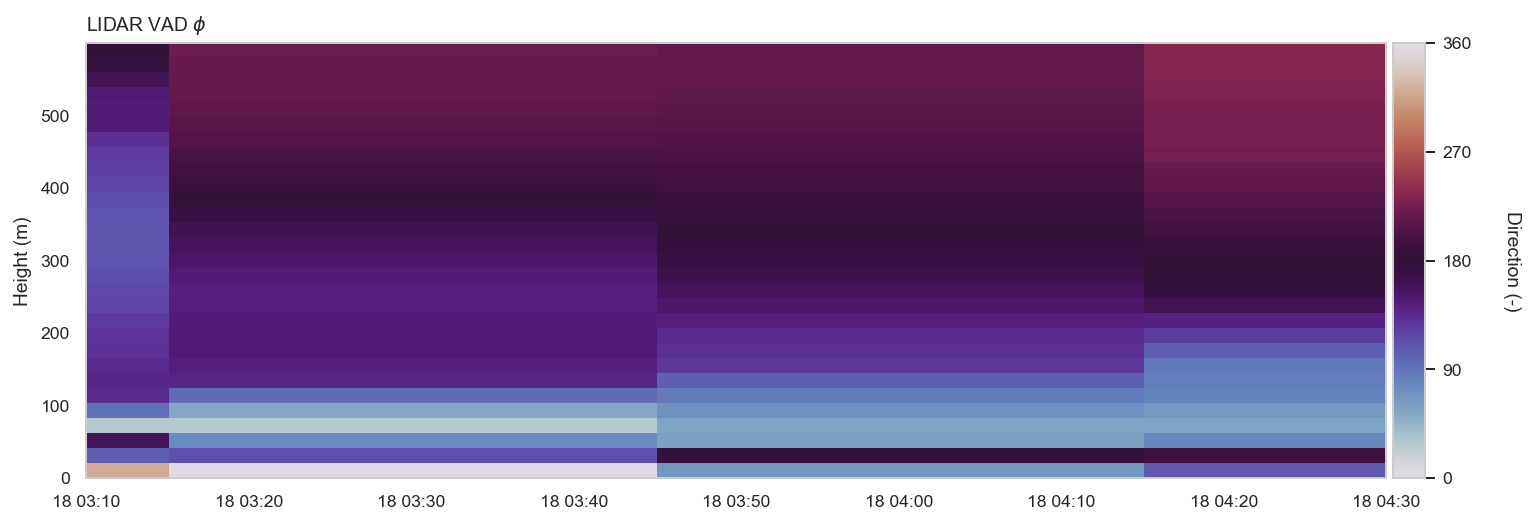

In [117]:
sns.set_context('paper')
# Prep the figure
fig = plt.figure(figsize=(12, 4))
widths = [1, 0.025]
nrows = 1
ncols = 2
spec = fig.add_gridspec(ncols=ncols, nrows=nrows,
                        width_ratios=widths,
                        wspace=0.01, hspace=0.16)
ax_vad = fig.add_subplot(spec[0, 0])
ax_cbar = fig.add_subplot(spec[0, 1])

# Prep the data
ft = 'LOVE_Flyfox_190718'
tflight1 =  pd.Timestamp(flight_times[ft][0])
tflight2 = pd.Timestamp('2019-07-18 04:30')

# Prepare the LIDAR data
fl_lidar = lidar_vad.sel(time=slice(t1, t2))
lidar_z_max = 600
lidar_z_min = 0
lidar_z_ticks = np.arange(lidar_z_min, lidar_z_max, 100)

# LIDAR
ax = ax_vad
ax.set_facecolor('0.9')
color = lidar_vad.phi.T.values
im = ax.pcolormesh(
    lidar_vad.time,
    lidar_vad.z,
    color,
    cmap=plt.get_cmap('twilight'),
    linewidth=0,
    rasterized=True,
    vmin=0,
    vmax=360,
    shading='nearest',
)
im.set_edgecolor('face')
ax.set_ylabel('Height (m)')
ax.set_ylim(lidar_z_min, lidar_z_max)
ax.set_yticks(lidar_z_ticks)
ax.set_xlim(pd.Timestamp(tflight1), pd.Timestamp(tflight2))
cbar = fig.colorbar(im, cax=ax_cbar)
cbar.ax.set_ylabel('Direction (-)', rotation=270, labelpad=25)
cbar.set_ticks([0, 90, 180, 270, 360])
ax.set_title('LIDAR VAD $\phi$', loc='left')

Text(0.0, 1.0, 'LIDAR VAD')

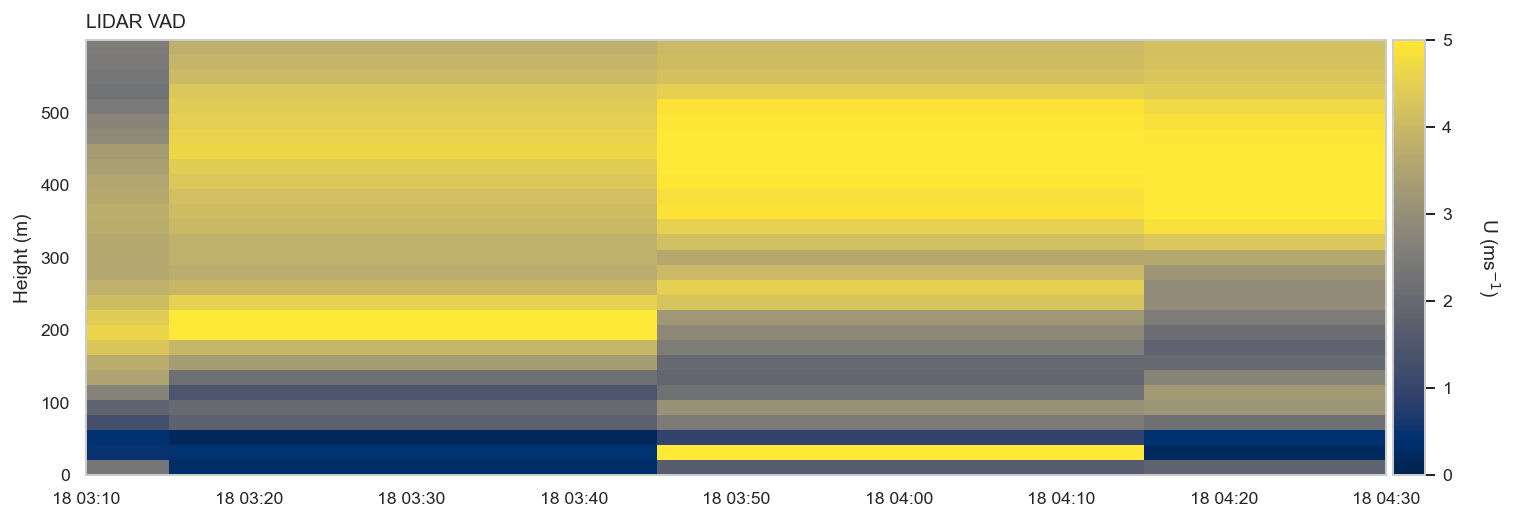

In [118]:
sns.set_context('paper')
# Prep the figure
fig = plt.figure(figsize=(12, 4))
widths = [1, 0.025]
nrows = 1
ncols = 2
spec = fig.add_gridspec(ncols=ncols, nrows=nrows,
                        width_ratios=widths,
                        wspace=0.01, hspace=0.16,
                       )
ax_vad = fig.add_subplot(spec[0, 0])
ax_cbar = fig.add_subplot(spec[0, 1])

# Prep the data
ft = 'LOVE_Flyfox_190718'
tflight1 =  pd.Timestamp(flight_times[ft][0])
tflight2 = pd.Timestamp('2019-07-18 04:30')

# Prepare the LIDAR data
fl_lidar = lidar_vad.sel(time=slice(t1, t2))
lidar_z_max = 600
lidar_z_min = 0
lidar_z_ticks = np.arange(lidar_z_min, lidar_z_max, 100)

# LIDAR
ax = ax_vad
ax.set_facecolor('0.9')
color = lidar_vad.mean_U.T.values
im = ax.pcolormesh(
    lidar_vad.time,
    lidar_vad.z,
    color,
    cmap=plt.get_cmap('cividis'),
    linewidth=0,
    rasterized=True,
    vmin=0,
    vmax=5,
    shading='nearest'
)
im.set_edgecolor('face')
ax.set_ylabel('Height (m)')
ax.set_ylim(lidar_z_min, lidar_z_max)
ax.set_yticks(lidar_z_ticks)
ax.set_xlim(pd.Timestamp(tflight1), pd.Timestamp(tflight2))
cbar = fig.colorbar(im, cax=ax_cbar)
cbar.ax.set_ylabel('U (ms$^{-1}$)', rotation=270, labelpad=25)
ax.set_title('LIDAR VAD', loc='left')

## Quick ploting examples of the CSAT data

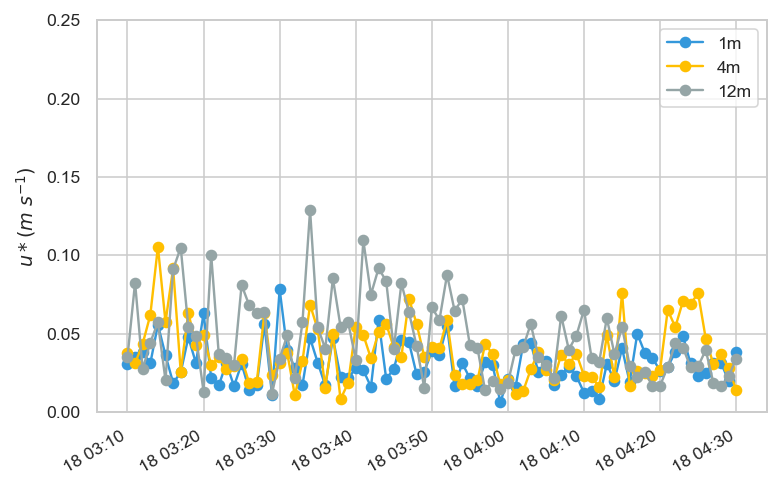

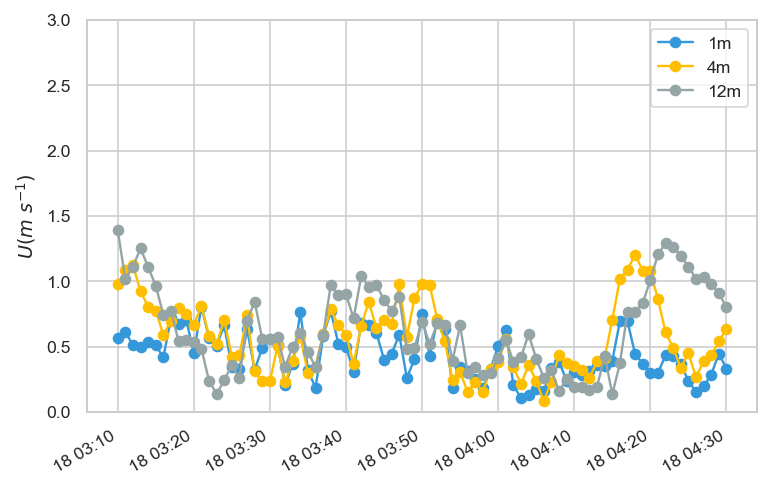

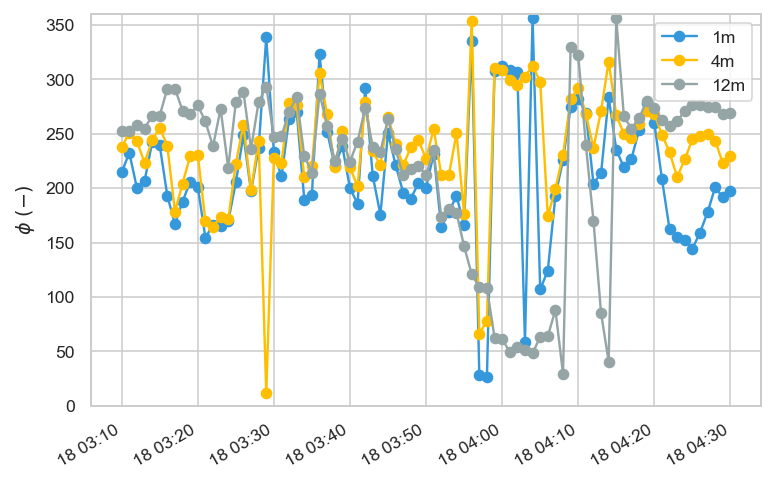

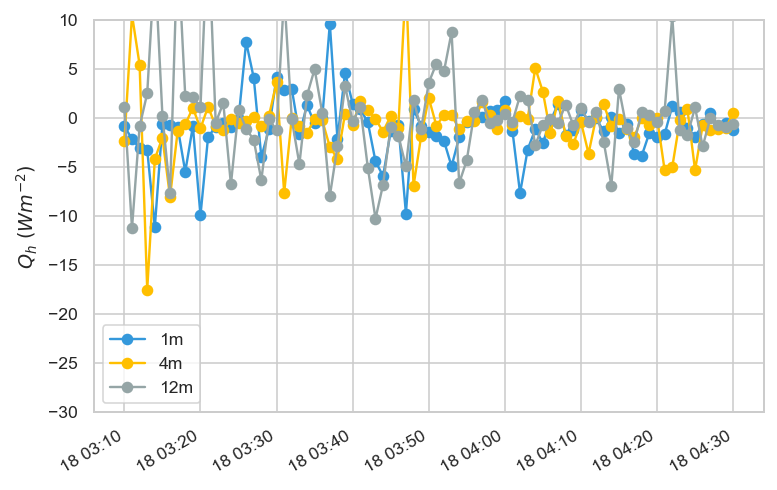

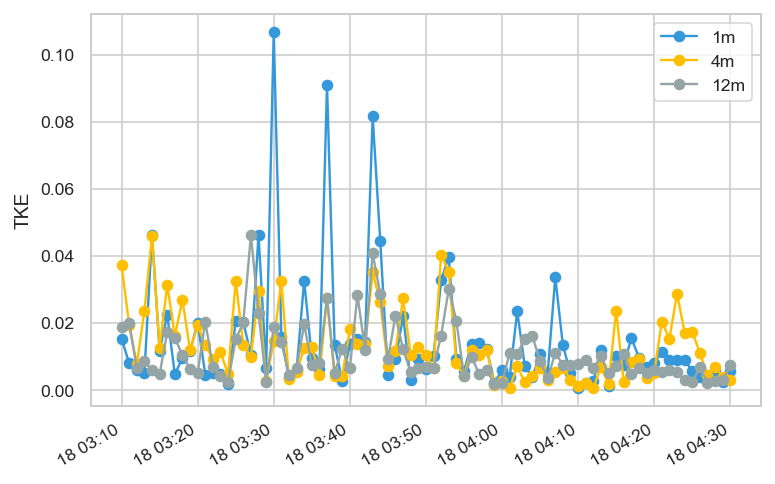

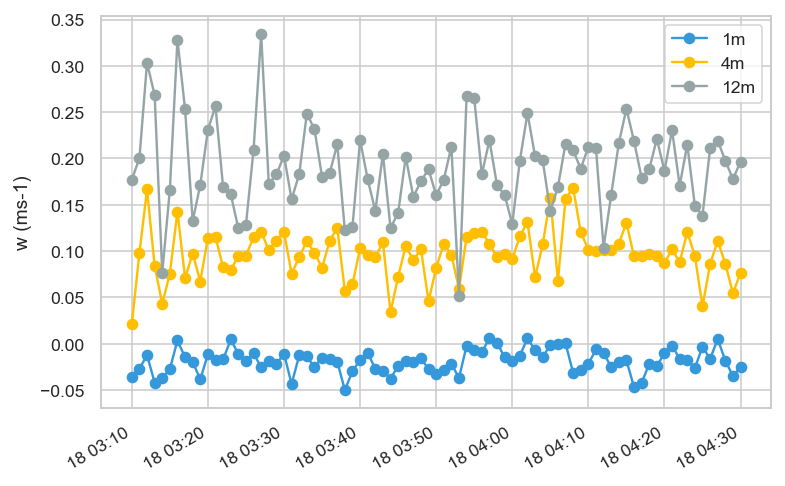

In [35]:
# Plot some interesting quantities
fig, ax = plt.subplots(1, 1)

for n in csat_names:
    ax.plot(ds_csat.time, ds_csat['u*'].sel(names=n), '-o', label=n)
ax.legend()
ax.set_ylabel('$u* (m~ s^{-1})$')
ax.set_ylim(0, 0.25)
fig.autofmt_xdate()

fig, ax = plt.subplots(1, 1)
for n in csat_names:
    ax.plot(ds_csat.time, ds_csat['U_scalar_mean_unrot'].sel(names=n), '-o', label=n)
ax.legend()
ax.set_ylabel('$U (m~ s^{-1})$')
ax.set_ylim(0, 3)
fig.autofmt_xdate()

fig, ax = plt.subplots(1, 1)
for n in csat_names:
    ax.plot(ds_csat.time, ds_csat['phi'].sel(names=n), '-o', label=n)
ax.legend()
ax.set_ylabel('$\phi~ (-)$')
fig.autofmt_xdate()
ax.set_ylim(0, 360)

fig, ax = plt.subplots(1, 1)
for n in csat_names:
    ax.plot(ds_csat.time, ds_csat['H'].sel(names=n), '-o', label=n)
ax.set_ylabel('$Q_h~ (Wm^{-2})$')
ax.legend()
ax.set_ylim(-30, 10)
fig.autofmt_xdate()

fig, ax = plt.subplots(1, 1)
for n in csat_names:
    ax.plot(ds_csat.time, ds_csat['TKE_mean'].sel(names=n), '-o', label=n)
ax.set_ylabel('TKE')
ax.legend()
fig.autofmt_xdate()

fig, ax = plt.subplots(1, 1)
for num, n in enumerate(csat_names):
    ax.plot(ds_csat.time, ds_csat['w_mean_unrot'].sel(names=n) + 0.1 * num, '-o', label=n)
ax.set_ylabel('w (ms-1)')
ax.legend()
fig.autofmt_xdate()

Generally there is a jumpiness that is probably not real. I suspect that the fog/condensation plays a role. Regardless of the source, the lowest CSAT is not reliable in this period, with the other CSATs also being less reliable at times.

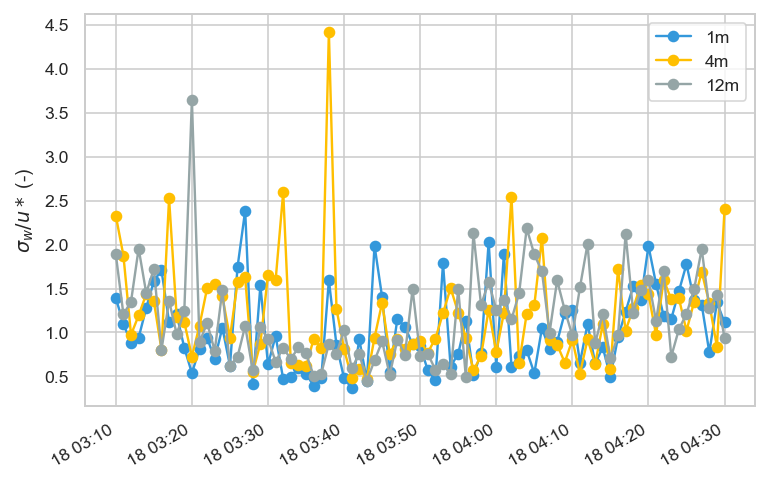

In [31]:
fig, ax = plt.subplots(1, 1)
for n in csat_names:
    ax.plot(ds_csat.time, ds_csat['w_std_unrot'].sel(names=n) / ds_csat['u*'].sel(names=n) , '-o', label=n)
ax.set_ylabel('$\sigma_w / u*$ (-)')
ax.legend()
fig.autofmt_xdate()

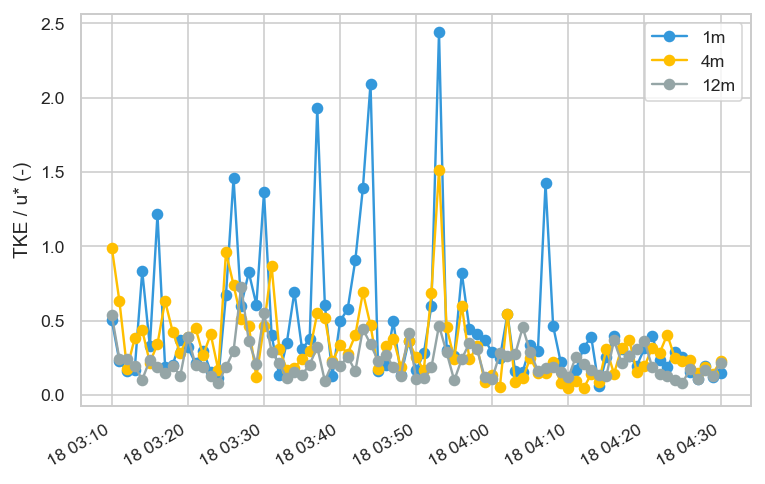

In [54]:
fig, ax = plt.subplots(1, 1)
for n in csat_names:
    ax.plot(ds_csat.time, ds_csat['TKE_mean'].sel(names=n) / ds_csat['u*'].sel(names=n) , '-o', label=n)
ax.set_ylabel('TKE / u* (-)')
ax.legend()
fig.autofmt_xdate()

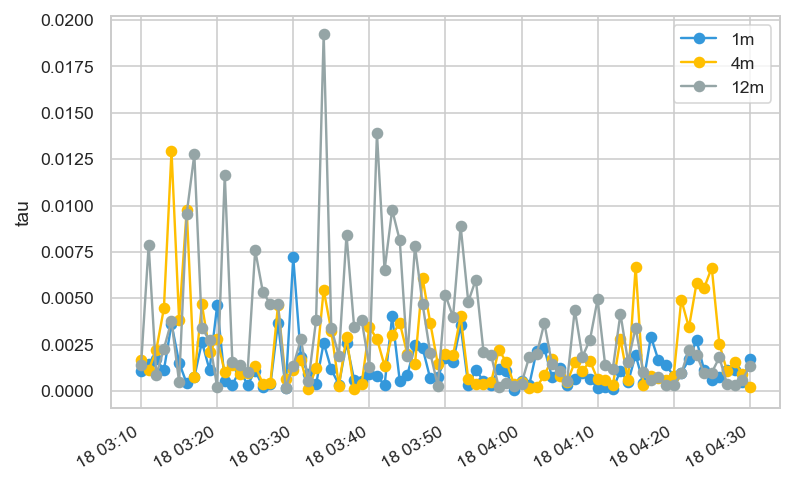

In [121]:
fig, ax = plt.subplots(1, 1)
for n in csat_names:
    ax.plot(ds_csat.time, ds_csat['tau'].sel(names=n), '-o', label=n)
ax.set_ylabel('tau')
ax.legend()
fig.autofmt_xdate()

Quick comparison between sonic and DTS wind speed 

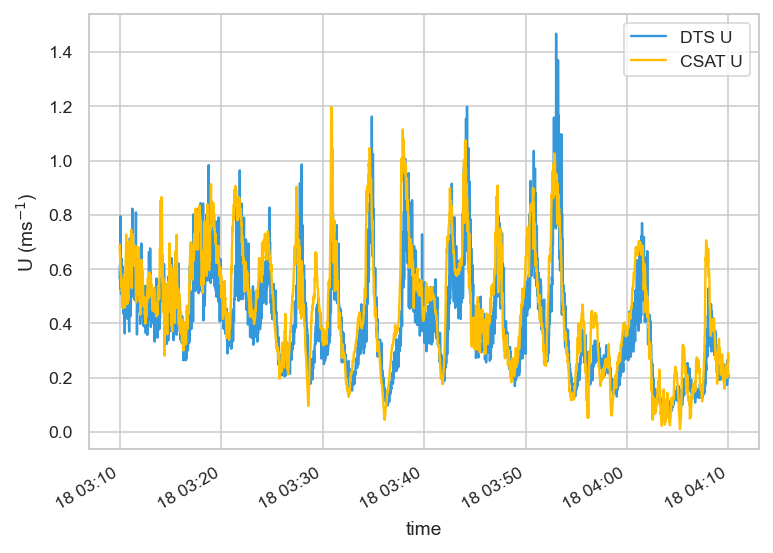

In [197]:
tower_wind_speed.swap_dims({'xyz': 'z'}).sel(z=1.25, method='nearest').sel(time=tslice).plot(label='DTS U')
np.sqrt(csat_ts_1s.S1m_Ux ** 2 + csat_ts_1s.S1m_Uy ** 2).plot(label='CSAT U')
plt.gca().set_ylabel('U (ms$^{-1}$)')
plt.gca().legend()

Text(0.5, 0, 'CSAT U (ms$^{-1}$)')

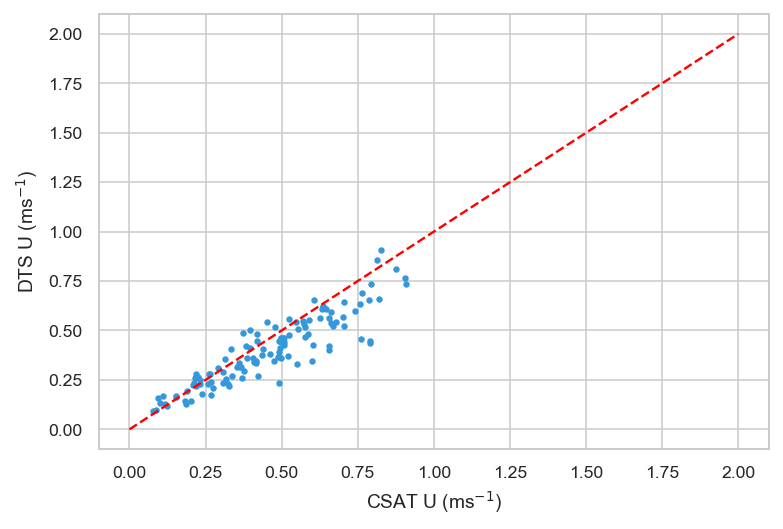

In [207]:
plt.scatter(
    np.sqrt(csat_ts_1s.S1m_Ux ** 2 + csat_ts_1s.S1m_Uy ** 2).sel(time=tslice).isel(time=slice(None, -1)).resample(time='30s').mean(),
    tower_wind_speed.swap_dims({'xyz': 'z'}).sel(z=1.25, method='nearest').sel(time=tslice).resample(time='30s').mean(),
    marker='.'
)
plt.plot([0, 2], [0, 2], 'r--')
plt.gca().set_ylabel('DTS U (ms$^{-1}$)')
plt.gca().set_xlabel('CSAT U (ms$^{-1}$)')



In [203]:
tower_wind_speed.sel(time=tslice)

<xarray.DataArray (time: 3600, xyz: 80)>
array([[0.38847898, 0.52505436, 0.53416312, ..., 1.21105781, 0.71199222,
        1.14868157],
       [0.54187504, 0.52505554, 0.58466762, ..., 1.61698782, 1.81404305,
        0.96307069],
       [0.43422634, 0.48869966, 0.53290391, ..., 1.51930468, 1.59351093,
        1.35622956],
       ...,
       [0.17064802, 0.15962332, 0.24539167, ..., 0.3275132 , 0.3129257 ,
        0.32132507],
       [0.14187921, 0.1642199 , 0.2048341 , ..., 0.35524111, 0.30672053,
        0.29518626],
       [0.13478254, 0.16521234, 0.17573293, ..., 0.26231565, 0.31148533,
        0.36776049]])
Coordinates:
  * time      (time) datetime64[ns] 2019-07-18T03:10:00 ... 2019-07-18T04:09:59
    x         (xyz) float64 -14.15 -14.14 -14.14 -14.13 ... -13.87 -13.87 -13.86
    y         (xyz) float64 -9.188 -9.189 -9.19 -9.191 ... -9.278 -9.279 -9.28
    LAF       (xyz) float64 204.1 203.9 203.8 203.7 ... 194.4 194.3 194.2 194.0
    heated    (xyz) object 'tower' 'tower' 'tower' ... 'tower' 'tower' 'tower'
    z         (xyz) float64 0.7173 0.8461 0.9749 1.104 ... 10.64 10.77 10.9
    unheated  (xyz) object 'tower' 'tower' 'tower' ... 'tower' 'tower' 'tower'
Dimensions without coordinates: xyz

In [204]:
csat_ts_1s

<xarray.Dataset>
Dimensions:     (time: 3601)
Coordinates:
  * time        (time) datetime64[ns] 2019-07-18T03:10:00 ... 2019-07-18T04:1...
Data variables: (12/20)
    S12m_Ux     (time) float64 1.305 1.352 1.364 1.346 ... 0.0938 0.0619 0.075
    S12m_Uy     (time) float64 0.4924 0.5084 0.5368 ... -0.2538 -0.1927 -0.169
    S12m_Uz     (time) float64 0.0045 0.02755 0.02505 ... -0.1283 -0.1578 -0.146
    S12m_Ts     (time) float64 9.793 9.851 9.899 9.875 ... 8.484 8.46 8.46 8.46
    S12m_diag   (time) float64 15.5 35.5 49.1 11.5 31.5 ... 19.5 39.5 40.3 6.0
    S4m_Ux      (time) float64 0.6713 0.5214 0.3273 ... 0.3334 0.3167 0.315
    ...          ...
    S1m_diag    (time) float64 13.5 33.5 53.5 9.5 29.5 ... 17.5 37.5 44.7 4.0
    S0p5m_Ux    (time) float64 -0.02165 -0.03565 -0.0421 ... -1.059 -0.531
    S0p5m_Uy    (time) float64 0.2505 0.218 0.2308 0.2007 ... 1.556 1.781 0.892
    S0p5m_Uz    (time) float64 0.0014 -0.0033 -0.0154 ... -0.5106 -0.5803 -0.286
    S0p5m_Ts    (time) float64 7.752 7.67 7.777 7.569 ... 12.86 12.81 13.14
    S0p5m_diag  (time) float64 11.5 31.5 51.5 ... 4.126e+03 4.146e+03 4.157e+03